# Finding the best "hygge" path
This notebook explores the different ways of finding the shortest path while ensuring that the path is "hyggelig"

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from collections import Counter
from random import choice

## Load base street paths

In [2]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

## Compute bird features
This code is an excerpt from `birds.ipynb`. Birds are attributed to an edge if a 50m buffer around the bird intersects with a given street.

In [3]:
birds = pd.read_csv('../data/birds.csv')
birds = birds.drop(columns='Unnamed: 0')

gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

# project to EPSG:25832
gdf = gdf.to_crs('EPSG:25832')

In [4]:
# remove observations outside of Copenhagen
# load shape of Copenhagen
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
cph = ox.geocode_to_gdf(geocodes)
cph = cph.to_crs('EPSG:25832')
cph_poly = cph.dissolve().geometry.iloc[0]

# find intersecting bird observations
gdf['intersection_geometry'] = gdf.geometry.intersection(cph_poly)

In [5]:
# remove observations without exact coordinates
gdf = gdf[~gdf.intersection_geometry.is_empty]

In [6]:
# create a buffer around each observation
buffer_radius = 50  # radius (in meters due to EPSG:25832)
gdf['buffer'] = gdf.buffer(buffer_radius)
gdf_buffer = gdf.set_geometry('buffer')

In [7]:
intersections = edges.sjoin(gdf_buffer)
intersections = gpd.GeoDataFrame(intersections, geometry=intersections.geometry_left, crs=gdf.crs)

In [8]:
bird_counts = intersections.groupby(['u', 'v', 'key']).size()
bird_counts.name = 'bird_counts'

In [9]:
edges = edges.merge(bird_counts, left_index=True, right_index=True, how='left')

In [10]:
edges['bird_counts'] = edges.bird_counts.fillna(0)
edges['birds_per_m'] = edges['bird_counts'] / edges['length']

## Find best path minimizing distance and maximizing birds
### Weighted sum of features
This method does not really work but ¯\\\_(ツ)\_/¯

One approach to finding the shortest path maximizes "hygge" is to weight each feature, and find the shortest path on this new composite feature. We use minmax scaling to get our features down into a comparable range
$$
x_{scaled} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$
For the birds, we use $1-x_{scaled}$ as the feature, such that we can minimize the feature to maximize bird sightings

In [11]:
edges['w1'] = (edges['length'] - edges['length'].min()) / (edges['length'].max() - edges['length'].min())
edges['w2'] = ((edges['bird_counts'] - edges['bird_counts'].min()) / (edges['bird_counts'].max() - edges['bird_counts'].min()))

We can now create a "hygge" score as a weighted sum of the relevant features. The specific weights are parameters that need to be tuned for optimal routing.

In [12]:
edges['w'] = 0.9 * edges['w1'] + 0.1 * edges['w2']

We create a graph with the new hygge score on each edge.

In [13]:
G = ox.graph_from_gdfs(nodes, edges)

This new hygge score is designed to be minimized. By using traditional shortest path algorithms, we can find the path that minimizes the hygge score, which in turn leads to minimizing path length and maximizing bird sightings.

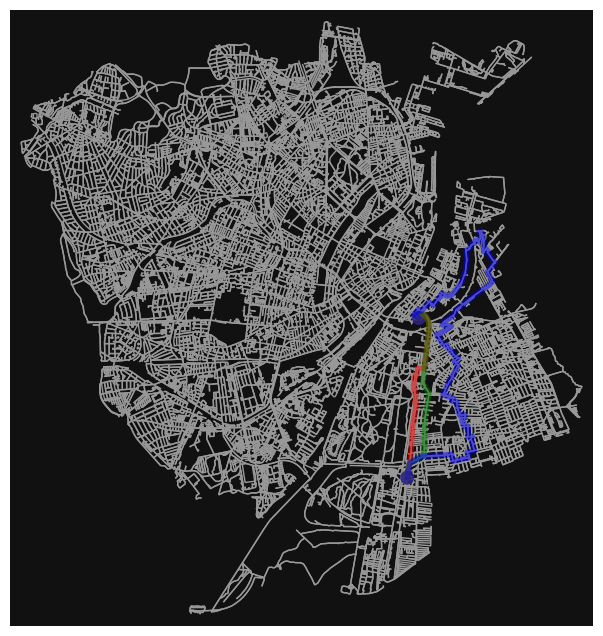

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
#orig = 118738
#dest = 1578270263

orig = choice(list(G.nodes))
dest = choice(list(G.nodes))

route_w = ox.shortest_path(G, orig, dest, weight='w')
route_l = ox.shortest_path(G, orig, dest, weight='w1')
route_b = ox.shortest_path(G, orig, dest, weight='w2')
routes = [route_w, route_l, route_b]
route_labels = ['w path', 'length path', 'bird path']
ox.plot_graph_routes(G, routes, node_alpha=0, route_colors=['red', 'green', 'blue'])

In [16]:
for route, label in zip(routes, route_labels):
    print(label)
    print('length:', nx.path_weight(G, route, weight='length'))
    print('birds :', nx.path_weight(G, route, weight='bird_counts'))
    print('w     :', nx.path_weight(G, route, weight='w'))
    print()


w path
length: 4106.302999999999
birds : 144.0
w     : 1.6915684888048241

length path
length: 4104.6849999999995
birds : 421.0
w     : 1.71789081961938

bird path
length: 12461.534000000001
birds : 42.0
w     : 5.1107615996596065



## Shortening hygge roads
An alternative approach would be to classify roads as either "hyggelige" or neutral. With this binary classification, we can then encourage the use of hygge roads by shortening hygge paths by some factor.

<Axes: xlabel='birds_per_m', ylabel='Count'>

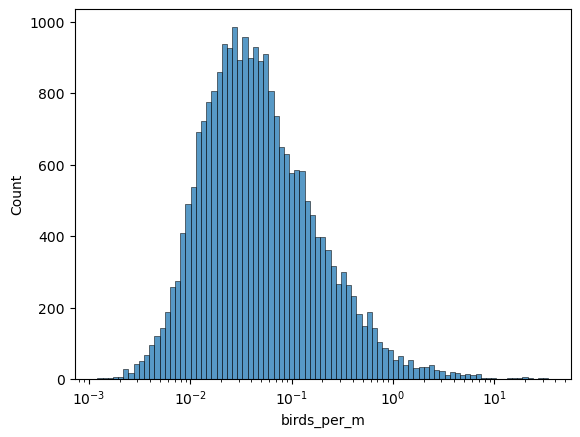

In [17]:
sns.histplot(data=edges, x='birds_per_m', log_scale=True)

The vast majority of edges have `birds_per_m = 0`. This is important to take into consideration when defining reasonable intervals. For now, use the $0.9th$ quantile of `birds_per_m` as a threshold for finding the roads with a lot of birds.

In [18]:
bins = edges.birds_per_m.quantile([0, 0.9, 1])
edges['birds_per_m_cat'] = pd.cut(edges.birds_per_m, bins, labels=['normal', 'bird path'], include_lowest=True)

<Axes: xlabel='birds_per_m', ylabel='Count'>

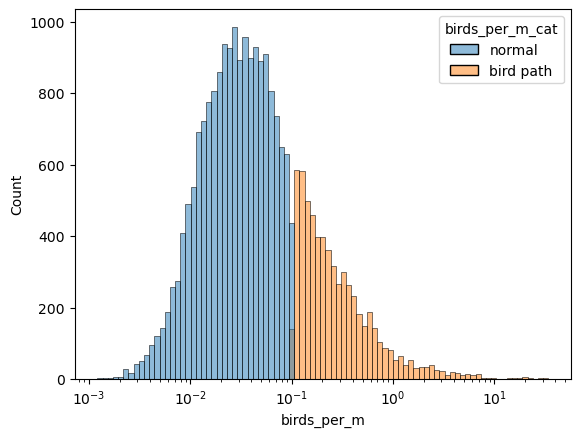

In [19]:
sns.histplot(data=edges, x='birds_per_m', log_scale=True, hue='birds_per_m_cat')

In [20]:
for i in np.linspace(0, 1, 11):
    i = np.round(i, 1)
    edges[f'birds_boost{i}'] = edges.birds_per_m_cat.map({'normal': 1, 'bird path': i}).astype(float)
    edges[f'w{i}'] = edges['length'] * edges[f'birds_boost{i}']

In [26]:
edges['hyggelength'] = edges.apply(lambda x: x.length if x.birds_per_m_cat == 'bird path' else 0, axis=1)
edges['nonhyggelength'] = edges.apply(lambda x: x.length if x.birds_per_m_cat != 'bird path' else 0, axis=1)

In [28]:
G = ox.graph_from_gdfs(nodes, edges)

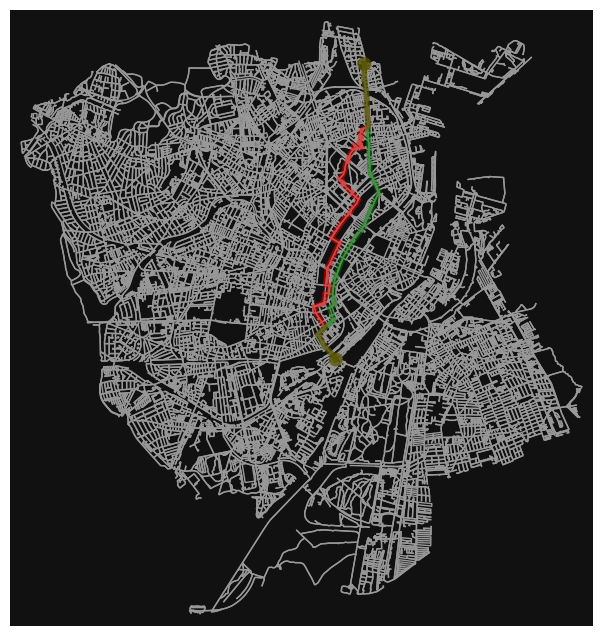

w path
length: 8436.241000000002
hyggelength: 2656.2329999999993
nonhyggelength: 5780.008000000001
birds : 732.0
w     : 6576.8779

length path
length: 7327.679999999999
hyggelength: 237.839
nonhyggelength: 7089.840999999999
birds : 129.0
w     : 7161.1927



In [36]:
orig = 118738
dest = 1578270263

#orig = 1783390939
#dest = 11807672519

w = 'w0.3'
route_w = ox.shortest_path(G, orig, dest, weight=w)
route_l = ox.shortest_path(G, orig, dest, weight='length')
routes = [route_w, route_l]
route_labels = ['w path', 'length path']
ox.plot_graph_routes(G, routes, node_alpha=0, route_colors=['red', 'green'])

for route, label in zip(routes, route_labels):
    print(label)
    print('length:', nx.path_weight(G, route, weight='length'))
    print('hyggelength:', nx.path_weight(G, route, weight='hyggelength'))
    print('nonhyggelength:', nx.path_weight(G, route, weight='nonhyggelength'))
    print('birds :', nx.path_weight(G, route, weight='bird_counts'))
    print('w     :', nx.path_weight(G, route, weight=w))
    print()

In [38]:
samples = []

for n in range(10):
    orig = choice(list(G.nodes))
    dest = choice(list(G.nodes))

    for i in np.linspace(0, 1, 11):
        i = np.round(i, 1)
        w = f'w{i}'
        route_w = ox.shortest_path(G, orig, dest, weight=w)
        route_l = ox.shortest_path(G, orig, dest, weight='length')
        
        samples.append([
            orig, 
            dest, 
            w, 
            nx.path_weight(G, route_w, weight='length'),
            nx.path_weight(G, route_w, weight='bird_counts'),
            nx.path_weight(G, route_w, weight='hyggelength'),
            nx.path_weight(G, route_w, weight='nonhyggelength'),
            nx.path_weight(G, route_l, weight='length'),
            nx.path_weight(G, route_l, weight='bird_counts'),
            nx.path_weight(G, route_l, weight='hyggelength'),
            nx.path_weight(G, route_l, weight='nonhyggelength'),
            route_w, 
            route_l
        ])

In [39]:
routes_df = pd.DataFrame(
    samples, 
    columns=[
        'u', 'v', 'w', 
        'path_length', 'path_birds', 'path_hyggelength', 'path_nonhyggelength', 
        'raw_path_length', 'raw_path_birds', 'raw_hyggelength', 'raw_nonhyggelength', 
        'route_w', 'route_l'])

In [42]:
routes_df['reroute'] = routes_df['path_nonhyggelength'] / routes_df['raw_nonhyggelength']

In [43]:
routes_df[routes_df.u == routes_df.u.unique()[1]]

,u,v,w,path_length,path_birds,path_hyggelength,path_nonhyggelength,raw_path_length,raw_path_birds,raw_hyggelength,raw_nonhyggelength,route_w,route_l,reroute
11,4513737661,1633913868,w0.0,3831.090,291.0,740.556,3090.534,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.912525
12,4513737661,1633913868,w0.1,3829.782,374.0,739.248,3090.534,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.912525
13,4513737661,1633913868,w0.2,3829.782,374.0,739.248,3090.534,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.912525
14,4513737661,1633913868,w0.3,3829.782,374.0,739.248,3090.534,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.912525
15,4513737661,1633913868,w0.4,3671.763,494.0,511.132,3160.631,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.933222
16,4513737661,1633913868,w0.5,3671.763,494.0,511.132,3160.631,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.933222
17,4513737661,1633913868,w0.6,3671.763,494.0,511.132,3160.631,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.933222
18,4513737661,1633913868,w0.7,3671.763,494.0,511.132,3160.631,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.933222
19,4513737661,1633913868,w0.8,3671.763,494.0,511.132,3160.631,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",0.933222
20,4513737661,1633913868,w0.9,3636.273,98.0,249.480,3386.793,3636.273,98.0,249.48,3386.793,"[4513737661, 10776414, 17852715, 7912660887, 1...","[4513737661, 10776414, 17852715, 7912660887, 1...",1.000000


In [44]:
lol = np.array(routes_df.groupby(['u', 'v'])['reroute'].apply(lambda x: list(x)).to_list())

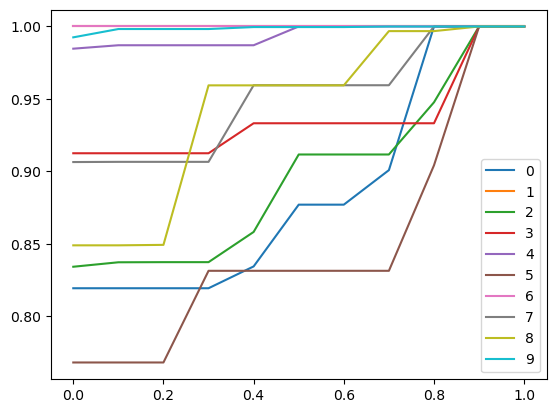

In [45]:
f, ax = plt.subplots()
for i, row in enumerate(lol):
    ax.plot(np.linspace(0, 1, 11), row, label=i)
ax.legend()